In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pylab as plt

import chainer
import chainer.links as L
import chainer.functions as F

import varit
import varit.random_variables as rv
from varit.models import jmvae

In [3]:
%matplotlib inline

In [4]:
gpu = 0

# load data

In [5]:
mnist = chainer.datasets.get_mnist()

# define network

In [6]:
class Net1out(chainer.Chain):
    def __init__(self, sensor, hidden, latent):
        super().__init__(
            l1=L.Linear(sensor, hidden),
            l2=L.Linear(hidden, hidden),
            l3=L.Linear(hidden, hidden),
            m0=L.Linear(hidden, latent),
        )

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        m0 = self.m0(h)
        return m0

In [7]:
class Net2out(chainer.Chain):
    def __init__(self, sensor, hidden, latent):
        super().__init__(
            l1=L.Linear(sensor, hidden),
            l2=L.Linear(hidden, hidden),
            l3=L.Linear(hidden, hidden),
            m0=L.Linear(hidden, latent),
            m1=L.Linear(hidden, latent)
        )

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        m0 = self.m0(h)
        m1 = self.m1(h)
        return m0, m1

# define model

In [8]:
sensor_x = 28 * 28
sensor_y = 10
hidden = 1024
zdim_z = 40

qzgxy  = rv.ConditionalGaussian(Net2out(sensor_x + sensor_y, hidden, zdim_z))
qzgx  = rv.ConditionalGaussian(Net2out(sensor_x, hidden, zdim_z))
qzgy  = rv.ConditionalGaussian(Net2out(sensor_y, hidden, zdim_z))
pxgz = rv.ConditionalBernoulli(Net1out(zdim_z, hidden, sensor_x))
pygz = rv.ConditionalCategorical(Net1out(zdim_z, hidden, sensor_y))

model = jmvae.JMVAE(qzgxy, qzgx, qzgy, pxgz, pygz)

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [9]:
if 0 <= gpu:
    model.to_gpu(gpu)
    xp = chainer.cuda.cupy
    chainer.cuda.get_device(gpu).use()
else:
    xp = np

In [10]:
n_epoch = 50
n_warmup = 20
batchsize = 100
N = mnist[0].__len__()

sum_loss_log = []

for epoch in range(0, n_epoch):
    C = np.min([epoch/n_warmup, 1])
    print('epoch={}, C={}'.format(epoch, C))

    perm = np.random.permutation(N)
    
    sum_loss = 0
    for i in range(0, N, batchsize):
        images, labels = mnist[0].__getitem__([perm[i:i + batchsize]])
        x_batch = chainer.Variable(xp.array(images))
        y_batch = chainer.Variable(xp.array(varit.utils.one_hot(labels)))
        loss = model.lower_bound(x_batch, y_batch, C=C, alpha=0.1)
        
        sum_loss += float(loss.data) * batchsize
        model.zerograds()
        loss.backward()
        optimizer.update()
        
    sum_loss_log.append(sum_loss / N)
    print('train mean loss={}'.format(sum_loss / N))

epoch=0, C=0.0
train mean loss=196.92886746724446
epoch=1, C=0.05
train mean loss=181.07498565673828
epoch=2, C=0.1
train mean loss=174.64624890645345
epoch=3, C=0.15
train mean loss=169.71527971903484
epoch=4, C=0.2
train mean loss=167.7092182413737
epoch=5, C=0.25
train mean loss=166.4358745574951
epoch=6, C=0.3
train mean loss=165.48407758076985
epoch=7, C=0.35
train mean loss=165.15610590616862
epoch=8, C=0.4
train mean loss=164.84401565551758
epoch=9, C=0.45
train mean loss=164.2771886444092
epoch=10, C=0.5
train mean loss=164.18466219584147
epoch=11, C=0.55
train mean loss=163.8372736867269
epoch=12, C=0.6
train mean loss=163.92968864440917
epoch=13, C=0.65
train mean loss=163.75626892089844
epoch=14, C=0.7
train mean loss=163.465661239624
epoch=15, C=0.75
train mean loss=163.80192354838053
epoch=16, C=0.8
train mean loss=163.83973678588868
epoch=17, C=0.85
train mean loss=163.88562037150066
epoch=18, C=0.9
train mean loss=163.9683740234375
epoch=19, C=0.95
train mean loss=163.99

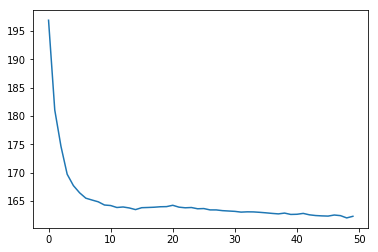

In [11]:
plt.plot(sum_loss_log)

In [12]:
model.to_cpu()
xp = np

In [13]:
model_file_name = 'jmvae_mnist'

In [14]:
print('save the model')
chainer.serializers.save_npz(model_file_name + '.model', model)
print('save the optimizer')
chainer.serializers.save_npz(model_file_name + '.state', optimizer)

save the model
save the optimizer


In [15]:
print('load the model')
chainer.serializers.load_npz(model_file_name + '.model', model)
print('load the optimizer')
chainer.serializers.load_npz(model_file_name + '.state', optimizer)

load the model
load the optimizer


In [16]:
train_ind = [np.where(mnist[1].__getitem__(range(100))[1] == i)[0][0] for i in range(10)]
images, labels = mnist[1].__getitem__(train_ind)
x_batch = chainer.Variable(xp.array(images))
y_batch = chainer.Variable(xp.array(varit.utils.one_hot(labels)))
with chainer.no_backprop_mode(), chainer.using_config('train', False):
    px, py = model.reconstract(x_batch, y_batch)

[0 1 2 3 4 5 6 7 8 9]


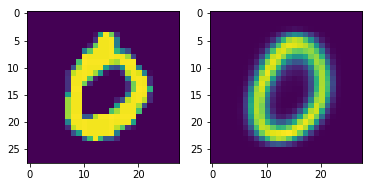

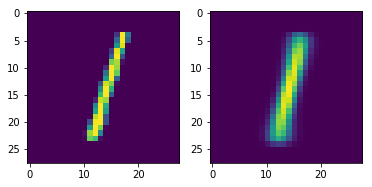

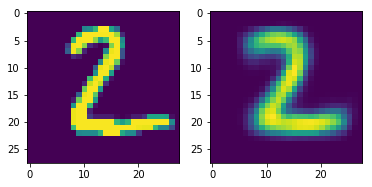

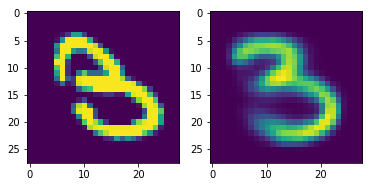

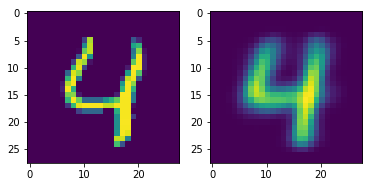

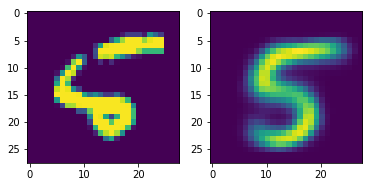

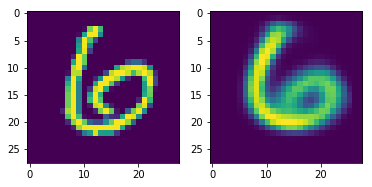

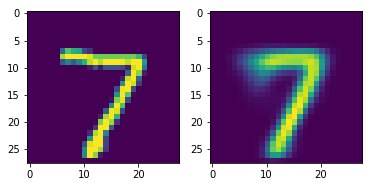

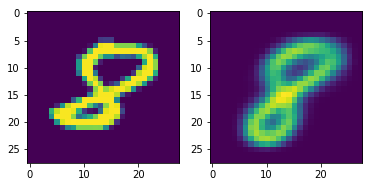

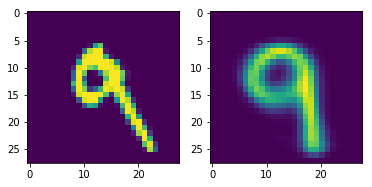

In [17]:
print(np.argmax(py.get_params().data, axis=1))
for i in range(len(px.get_params()[0])):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.subplot(1, 2, 2)
    plt.imshow(px.get_params()[0].data[i].reshape(28, 28))

In [18]:
train_ind = [np.where(mnist[1].__getitem__(range(100))[1] == i)[0][0] for i in range(10)]
images, labels = mnist[1].__getitem__(train_ind)
x_batch = chainer.Variable(xp.array(images))
y_batch = chainer.Variable(xp.array(varit.utils.one_hot(labels)))
with chainer.no_backprop_mode(), chainer.using_config('train', False):
    px, py = model.reconstract(y=y_batch)

[0 1 2 3 4 5 6 7 8 9]


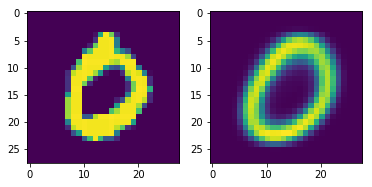

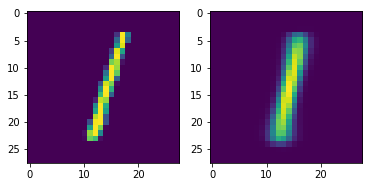

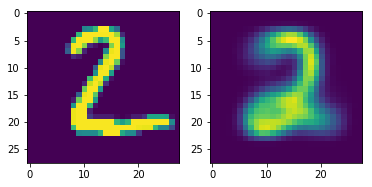

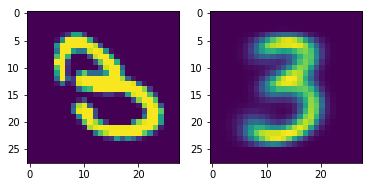

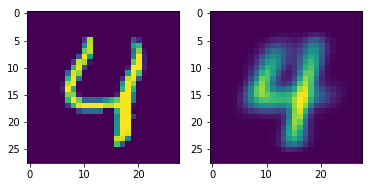

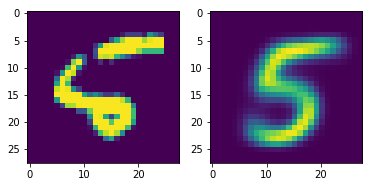

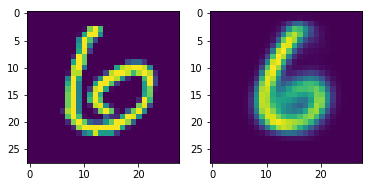

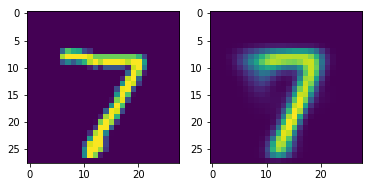

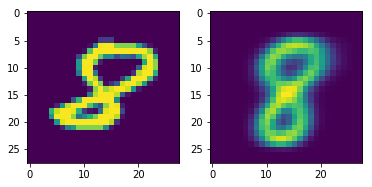

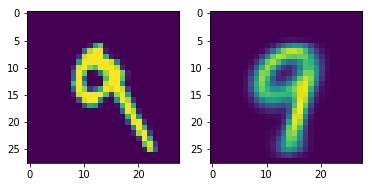

In [19]:
print(np.argmax(py.get_params().data, axis=1))
for i in range(len(px.get_params()[0])):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.subplot(1, 2, 2)
    plt.imshow(px.get_params()[0].data[i].reshape(28, 28))